## Linear Regression Refresh

*You can watch a [video](https://youtu.be/MQzG1hfhow4) of this lesson if you prefer.*

In the last [lesson](https://github.com/VikParuchuri/zero_to_gpt/blob/master/explanations/linreg.ipynb), we learned how to use gradient descent to train a linear regression algorithm.  In this lesson, we'll extend what we built to make a multi layer neural network.

Before we dive in, let's quickly refresh on linear regression.  Let's say we're trying to predict tomorrow's temperature (`tmax_tomorrow`) using today's max temperature (`tmax`), today's min temperature (`tmin`), and how much it rained today (`rain`).

We'll call tomorrow's temperature $y$, `tmax` $x_{1}$, `tmin` $x_{2}$, and `rain` $x_{3}$.

Then we can predict tomorrow's temperature using the equation $\hat{y}=w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{4} + b$.  $\hat{y}$ is our prediction for tomorrow's temperature.  The $w$ values are called weights, and the $b$ value is called a bias.

We multiply each of our $x$ values by its corresponding weight, then add in the bias.  In the last lesson, we learned how to calculate the $w$ and $b$ values.

## Nonlinearity

A big limitation of linear regression is that the prediction will always be linearly related to the inputs.  In real-world data, this is rarely the case.

Let's say we're predicting `tmax_tomorrow` using only `tmax`.  Then the equation is simplified to $\hat{y}=w_{1}x_{1} + b$.  We can say that $w_{1}$ is `.82`, and $b$ is `11.99`.

Now, let's load in our data and graph `tmax_tomorrow` and `tmax`:

<AxesSubplot: xlabel='tmax', ylabel='tmax_tomorrow'>

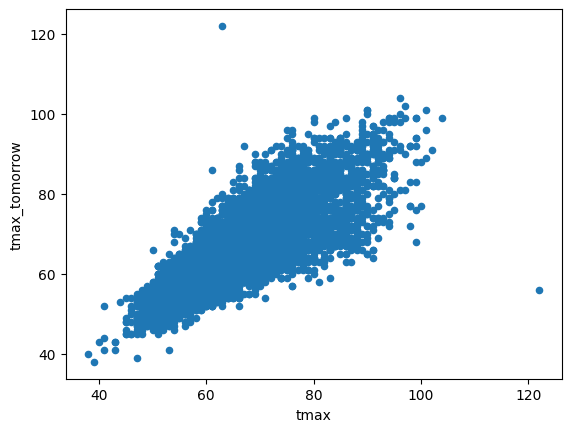

In [1]:
import pandas as pd

# Read in the data
data = pd.read_csv("../data/clean_weather.csv", index_col=0)
# Fill in any missing values in the data with past values
data = data.ffill()

# Create a scatter plot of tmax and tmax_tomorrow
data.plot.scatter("tmax", "tmax_tomorrow")

As you can see above, the relationship between `tmax` and `tmax_tomorrow` isn't perfectly linear.  We can show this by drawing a linear regression line using $w_{1}$ equals `.82`, and $b$ equals `11.99`.

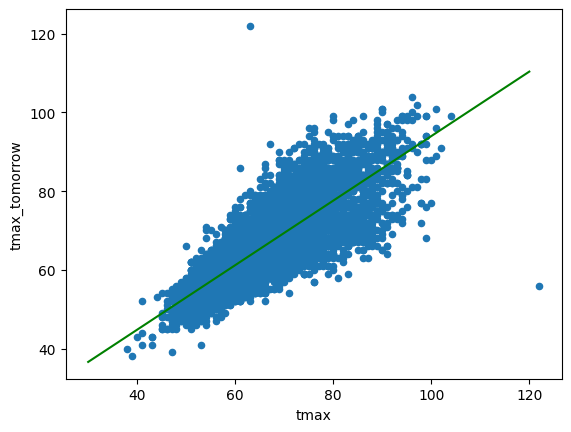

In [2]:
import matplotlib.pyplot as plt
data.plot.scatter("tmax", "tmax_tomorrow")

# Calculate the prediction given our weight and bias
prediction = lambda x, w1=.82, b=11.99: x * w1 + b

# Plot a linear regression line over our data
plt.plot([30, 120], [prediction(30),prediction(120)], 'green')

The line fits our data as well as a linear regression line can fit it (the mean squared error between the predictions and the actual `tmax_tomorrow` is as low as possible).

In [3]:
import numpy as np

def mse(actual, predicted):
    # Calculate mean squared error
    return np.mean((actual - predicted) ** 2)

# Error with the weight of .82 and the bias of 11.99
print(mse(data["tmax_tomorrow"], prediction(data["tmax"])))

# Error with a small shift in our weight, to .83, and in our bias, to 12
print(mse(data["tmax_tomorrow"], prediction(data["tmax"], .83, 12)))

22.897335324598416
23.489303834480715


As we can see above, even a small shift in our weight and bias away from our optimal values increases error.

But the error is stil fairly high.  This is because our linear regression model isn't properly capturing the nonlinear interactions in our data.  For example, if `tmax` is `100`, maybe `tmax_tomorrow` will be `tmax` times `.7`, but if `tmax` is `50`, `tmax_tomorrow` might be `tmax` times `.8`.

This type of relationship is nonlinear - the ratio between `tmax` and `tmax_tomorrow` isn't always a constant value like `.82`.

If we plot tomorrow's temperature versus today's temperature, we can see that this is in fact the case:

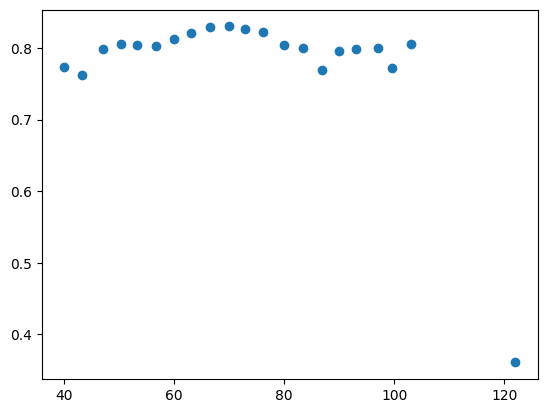

In [4]:
# Cut our tmax range into 25 bins
tmax_bins = pd.cut(data["tmax"], 25)

# Calculate the average ratio between tmax_tomorrow and tmax in each bin
ratios = (data["tmax_tomorrow"] - 11.99 )/ data["tmax"]
binned_ratio = ratios.groupby(tmax_bins).mean()

# Calculate the average tmax in each bin
binned_tmax = data["tmax"].groupby(tmax_bins).mean()

# Graph the tmax values versus the ratios
plt.scatter(binned_tmax, binned_ratio)

Linear regression can't capture this kind of nonlinearity properly, but neural networks can!

Neural networks add to linear regression in three important ways:

- A nonlinear transformation on top of the linear transformation
- Multiple layers, which can capture interactions between features
- Multiple hidden units, which each have slightly different linear and nonlinear transformations

## Activation Functions

Let's discuss each of these concepts separately.  First, nonlinear transformations, which are called activation functions.  The most common activation function used in neural networks is called a rectified linear unit, or **relu**.  Conceptually, relu is pretty straightforward.  Any value below zero is set to zero, and any value above zero is passed through as normal.

All of our temperature values are above zero, but let's generate some new temperatures to visualize what relu does.

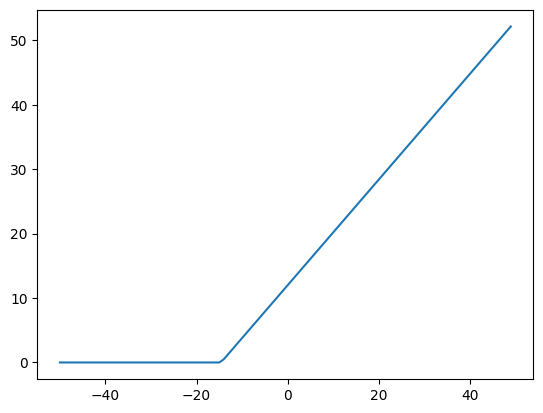

In [5]:
# Generate a range of predictions between -50 and 50.
temps = np.arange(-50,50)

# Predict tmax_tomorrow given each of our input temps
plt.plot(temps, np.maximum(0, prediction(temps)))

You can see that any predictions below 0 are set to 0.  This creates a nonlinear relationship between the input and the prediction.  In this example, if $w_{1}x_{1} + b$ is less than `0`, then the output prediction will be `0`.  If $w_{1}x_{1} + b$ is greater than `0`, then the prediction will be $w_{1}x_{1} + b$.

This means that the prediction is no longer linearly related to the input.

The equation for this looks like $\hat{y}=relu(w_{1}x_{1} + b)$.

## Multiple Layers

Of course, if all we did was add relu, our error would increase a lot!  This is because we'd be making the same prediction for any temperature less than 0.  To fix this, we use multiple layers in our neural network.

A neural network with two layers would have the equation $\hat{y}=w_{2}relu(w_{1}x_{1} + b) + b_{2}$.

We won't use an activation function on our output layer - this is the layer that we'll use in our predictions, so we need to not modify the value of the prediction.  This way, we can use a nonlinearity in our network, while still outputting a full range of predictions.

You might notice that this doesn't fully solve the problem, though.  If our first layer $relu(w_{1}x_{1} + b)$ return `0`, then multiplying by $w_{2}$ will still result in `0`.  We'd only be adding in $b_{2}$ to generate our output.

Here's a concrete example, with $w_{2}$ set to `.5`, and $b_{2}$ set to `10`

(0.0, 40.0)

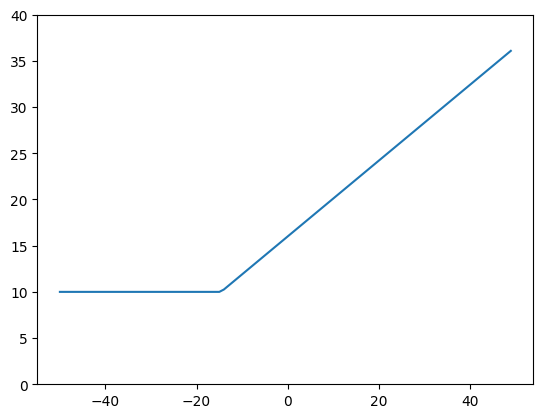

In [6]:
# Generate a range of predictions between -50 and 50.
temps = np.arange(-50,50)

# Predict tmax_tomorrow given each of our input temps
# Apply prediction twice to simulate 2 network layers
layer1 = np.maximum(0, prediction(temps))
layer2 = prediction(layer1, .5, 10)
plt.plot(temps, layer2)

# Set the y axis of the plot to start at 0
plt.ylim((0,40))

As you can see above, our predictions that are below zero have had $b_{2}$ of `10` added to them, but they're still all the same.  This is because if the output of `layer1` was `0`, then multiplying by $w_{2}$ still results in `0`.  So if the output of `layer1` is `0`, then `layer2` can only add in $b_{2}$, which is `10`.

This is a problem if we want to make accurate predictions - if `tmax` is below `0`, it's highly unlikely that `tmax_tomorrow` will always be `10`.

## Multiple Units

We can solve this by adding multiple units at each layer.  This will basically be running linear regression multiple times, with different weights and biases.

For example, we can run linear regression twice, with slightly different weights and biases.

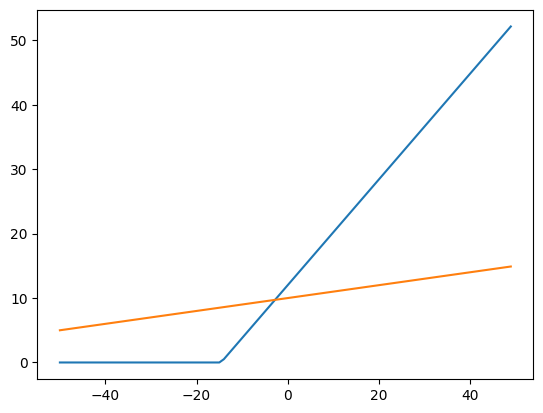

In [7]:
# Plot our first regression line, with w1 of .82, and b of 11.99
plt.plot(temps, np.maximum(0, prediction(temps)))

# Plot our second regression line, with w1 of .1, and b of 10
plt.plot(temps, np.maximum(0, prediction(temps, .1, 10)))

Above, we plotted two lines.  The first line is the output of the first unit in the first layer of the neural network, and the second line is the output of the second unit in the first layer.

As you can see, the second unit stays positive across the range of the input temperatures, and thus can pass temperature information to the next layer.  So we maintain a nonlinear relationship between `tmax` and the output while not just passing `0` to the next layer for all temperatures below `0`.

We can then pass the output of both units into the second layer of the network to get a prediction.

Let's take a quick look at a diagram of this neural network:

![2 layer network](images/dense/2layer_network.svg)

Then we can code this network, where $w_{1}$ is `.82`, $w_{2}$ is `.1`, $w_{3}$ is `.5`, $w_{4}$ is `.2`, $b_{1}$ is `11.99`, $b_{2}$ is `10`, and $b_{3}$ is `5`.

(0.0, 40.0)

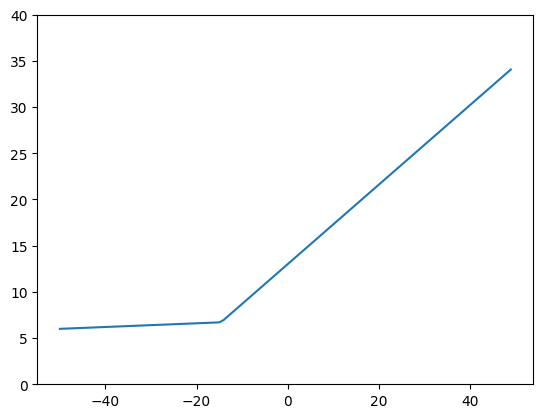

In [8]:
# Generate a range of predictions between -50 and 50.
temps = np.arange(-50,50)

# Predict tmax_tomorrow given each of our input temps
# Output from unit 1 of layer 1
layer1_unit1 = np.maximum(0, prediction(temps))
# Output from unit 2 of layer 1
layer1_unit2 = np.maximum(0, prediction(temps, .1, 10))
# Output from layer 2 - multiply the outputs of layer 1 unit 1 and layer 1 unit 2 by the respective weights, and add the bias
layer2 = prediction(layer1_unit1, .5, 0) + prediction(layer1_unit2, .2, 0) + 5
plt.plot(temps, layer2)

# Set the y axis of the plot to start at 0
plt.ylim((0,40))

This looks a lot better!  We now see that the network doesn't make the exact same prediction for all input temperatures below a certain value.  This is because the second layer was able to look at multiple inputs, and the output was only zeroed out in one of them.

This still enabled us to have a nonlinear relationship between the input and the output, but it also preserves the input signal - we still have some information about the original `tmax` in the second layer.

## Calculating Layer Outputs

In practice, we can use dozens or hundreds of layers and units in each layer.  It can get annoying to have to write out $w_{1}$, $w_{2}$, and so on.  To both make it easier to show the weights and biases, and faster to execute the network, we store our weights and biases in matrices.

![layer 1 weights](images/dense/layer1_weights.svg)

When weights are in matrices, we use matrix multiplication to multiply them with the inputs. Matrix multiplication works by multiplying each element of each row of the first matrix by each column of the second matrix, then adding them together:

![layer 1 weights](images/dense/matrix_mult.gif)

We can then add the biases to each row of the output.  Here is the full process of multiplying two input `tmax` values `80` and `90` by the weights and adding the bias.  Since there are two units in layer 1, we end up with two outputs for each input.  Each row in the output corresponds to a row in the input.

![layer 1 weights](images/dense/layer1_mult.svg)

The shapes of the matrices matter a lot in matrix multiplication.  The shape is the number of rows in a matrix by the number of columns, like `2x1`.  We can only multiply matrix A with matrix B if the number of columns in matrix A equals the number of rows in matrix B.

In the diagram above, we take a `2x1` matrix of `tmax` values, multiply by a `1x2` matrix of weights, then end up with a `2x2` matrix.  We then add a `1x2` matrix to this (which adds the bias values to each row).  The output is a `2x2` matrix.

We can implement our matrix multiplication in code.  We'll use a library called `tsensor` so you can see how the matrix shapes change:

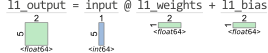

array([[77.59, 18.  ],
       [85.79, 19.  ],
       [93.99, 20.  ],
       [-4.41,  8.  ],
       [ 3.79,  9.  ]])

In [9]:
from tsensor import explain as exp

# Get 5 temperature values
input = np.array([[80], [90], [100], [-20], [-10]])

# Create the weight matrix, which is 1x2
l1_weights = np.array([[.82, .1]])

# Create the 1x2 bias matrix
l1_bias = np.array([[11.99, 10]])

# This is the output of the layer
with exp() as c:
    l1_output = input @ l1_weights + l1_bias

l1_output

As you can see above, the output is a `5x2` matrix, which results from the multiplication and the addition.  We get one output column for each input column.  We then need to apply relu to get the final result:

In [10]:
l1_activated = np.maximum(l1_output, 0)
l1_activated

array([[77.59, 18.  ],
       [85.79, 19.  ],
       [93.99, 20.  ],
       [ 0.  ,  8.  ],
       [ 3.79,  9.  ]])

We can rewrite our equation for layer 1 to use matrices - $layer_{1}=relu(XW_{1} + B_{1})$.  The capital letters indicate that we are multiplying and adding matrices, not single numbers.  This equation is much simpler to look at, especially when we add in a second layer $\hat{y}=W_{2}relu(XW_{1} + B_{1}) + B_{2}$.

Now, we can apply layer 2 on top of layer 1:

![layer 2 multiplied](images/dense/layer2_mult.svg)


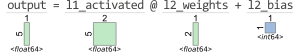

array([[47.395],
       [51.695],
       [55.995],
       [ 6.6  ],
       [ 8.695]])

In [11]:
l2_weights = np.array([
    [.5],
    [.2]
])

l2_bias = np.array([[5]])

# This is the output of the layer
with exp():
    output = l1_activated @ l2_weights + l2_bias

output

We then get a `5x1` output where each row corresponds to a prediction.  One nice way to think about neural network layers is that each layer generates new features in the data.  Our input had 1 feature `tmax`, and our first layer generated `2` new features to describe `tmax`.  Our second layer then compressed those `2` features back into one prediction for `tmax_tomorrow`.

One handy rule of thumb is that the number of rows in the weight matrix should equal the number of columns in the input matrix, and the number of columns in the weight matrix should equal the number of columns in the output matrix.  So in layer one, our weight matrix is `1x2` so we go from `1` feature in the input to `2` features in the output.

## Calculating W and B

We now know how to calculate the outputs of a neural network given $W$ and $B$.  This is called the forward pass of a neural network.

Let's learn how to calculate $W$ and $B$ from the data.  We'll be extending our work in the last lesson with gradient descent, which helps us find the $W$ and $B$ values that have the lowest error.  The difference this time is that we'll need to use backpropagation to transmit our loss gradient across multiple layers.

First of all, we need to calculate the loss between the actual `tmax_tomorrow` and our predictions.  We can do that using mean squared error, with the formula $\text{MSE}=(\hat{y} - y) ^ 2$.

Let's say these are our `tmax` and `tmax_tomorrow` values:

In [12]:
tmax = np.array([[80], [90], [100], [-20], [-10]])
tmax_tomorrow = np.array([[83], [89], [95], [-22], [-9]])

We can then calculate the mean squared error between the actual `tmax_tomorrow` and the `output`:

In [13]:
def mse(actual, predicted):
    return (actual - predicted) ** 2

In [14]:
mse(tmax_tomorrow, output)

array([[1267.716025],
       [1391.663025],
       [1521.390025],
       [ 817.96    ],
       [ 313.113025]])

We now have a mean squared error value corresponding to each of our outputs.  To begin backpropagation, we need to take the derivative of mean squared error, which will tell us which direction we need to adjust our prediction in to lower our loss:

In [15]:
def mse_grad(actual, predicted):
    return predicted - actual

mse_grad(tmax_tomorrow, output)

array([[-35.605],
       [-37.305],
       [-39.005],
       [ 28.6  ],
       [ 17.695]])

This tells us how to adjust each prediction to get it close to the actual value.

## Backpropagation Through Layers

Backpropagation will essentially reverse the forward pass to send the gradient to the various network parameters (weights and biases).  This gradient is how the network uses gradient descent to learn.

Here is the full forward pass of the network, with the operations we'll need to reverse:

![forward pass](images/dense/fwd.svg)

And here is how we'll reverse them:

![backward pass](images/dense/bwd.svg)

Now let's start reversing our operations, starting at the top of layer 2.

## Layer 2 Gradients

Now, we can calculate the gradient of our layer 2 parameters relative to our output gradient.  This is like undoing our forward pass, but with our error value as input.

We can first get our gradient with respect to our weights by multiplying the loss gradient by the output of layer 1:

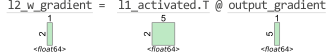

array([[-9562.0038],
       [-1741.73  ]])

In [16]:
output_gradient = mse_grad(tmax_tomorrow, output)

with exp():
    l2_w_gradient =  l1_activated.T @ output_gradient

l2_w_gradient

Let's discuss why this operation makes sense.  In the forward pass, we multiply each output of layer 1 by a weight to get the output of layer 2.  Let's use a diagram to visualize this. We'll leave the bias out to make things clearer:

![layer 2 backwards](images/dense/layer2_bw.svg)

The diagram above shows us how the inputs are multiplied by the weights in the forward pass to get the output.  As we can see, each weight is multiplied by multiple inputs.

Another way to think about this is that each weight is connected to multiple inputs and to multiple outputs:

![layer 2 backwards](images/dense/layer2_bw_conn.svg)

In the backward pass, we want to know whether to increase or decrease our weights.  The output gradient tells us how much each output needs to increase or decrease to reduce error.

To figure out how much each weight needs to change based on the output gradient, we need to look at each input connected to the weight, and reverse the operation we did in the forward pass.

This is because each weight affects several output values, and is scaled by several input values.  So multiplying the output gradient by the inputs that the weight is connected to tells us how much changing each weight will change the outputs:

![layer 2 backwards](images/dense/layer2_bw_grad.svg)

For example if $w_{1}$ is multiplied by an input of `90` to get one output, and by `80` to get another output, changing $w_{1}$ will change both outputs.  But it will change them proportionally to the input.  If we add `1` to $w_{1}$, then it will increase the first output by `90`, and the second output by `80`.  What we're doing in the backward pass is scaling the output gradient by the inputs to find the weight gradient.

Another way to think about it is reversing the weight connections:

![layer 2 backwards](images/dense/layer2_bw_grad_conn.svg)

We transpose the layer one output matrix (the inputs to layer 2) to ensure that each input that was connected to an output through a weight is multiplied by that output gradient.

If we multiply our output gradients by the inputs to the layer, it tells us how much we need to increase or decrease our weights:

![layer 2 backwards](images/dense/layer2_grad.svg)

This is due to the chain rule of partial derivatives, which we covered in the last lesson.  If we want to find the gradient with respect to the layer 2 weights, or $\frac{\partial L}{\partial W_{2}}$, we can write it out as a chain of multiplications:

$$\frac{\partial L}{\partial W_{2}}=\partial L\frac{\partial (XW_{2})}{\partial W_{2}}$$

In the equation above, $\partial L$ is really $\frac{\partial L}{\partial XW_{2}}$, but we just simplify it to make it easier to read.  The partial derivative of the loss with respect to the layer 2 weights is the partial derivative of the loss with respect to the layer 2 output $XW_{2}$ times the partial derivative of $XW_{2}$ with respect to $W_{2}$.  We'll leave the bias out just to make things simpler.

We know that $\partial L$ is $XW_{2} - Y$.  $XW_{2}$ is our output prediction, and the MSE gradient is `predicted - actual`.  Then we have to solve for $\frac{\partial (XW_{2})}{\partial W_{2}}$.  This is just $X$, since any change to $X$ will directly change the output $XW_{2}$.

So we can say that $\frac{\partial (XW_{2})}{\partial W_{2}} = X$, and that $\frac{\partial L}{\partial W_{2}} = \partial LX$.

If you ever want to verify derivatives, you can use the Python sympy library:

In [17]:
from sympy import diff, symbols

# Define symbols for our equation
x, w = symbols('X, W')
# Define input times weights in sympy
sympy_output = x * w
# Take the derivative of output with respect to w
diff(sympy_output, w)

X

What we're doing in the backward pass of the neural network is using the chain rule to take the partial derivatives of each parameter with respect to the loss.

The layer 2 bias equally affects all outputs.  If we increase the bias by `5`, all of the outputs will also be increased by `5`.  So the bias gradient is the average of all the output gradient values:

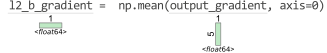

array([-13.124])

In [18]:
with exp():
    l2_b_gradient =  np.mean(output_gradient, axis=0)

l2_b_gradient

To update our layer 2 weights and biases, we need to subtract the gradient from the $W$ and $B$ values, adjusted by the learning rate.  You may recall that the learning rate prevents us from making updates to the parameters that are too large (which will move us away from the area of lowest error):

In [19]:
# Display original layer 2 weights
l2_weights

array([[0.5],
       [0.2]])

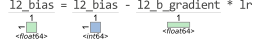

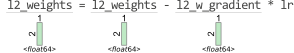

array([[0.59562004],
       [0.2174173 ]])

In [20]:
# Set a learning rate
lr = 1e-5

with exp():
    # Update the bias values
    l2_bias = l2_bias - l2_b_gradient * lr
    # Update the weight values
    l2_weights = l2_weights - l2_w_gradient * lr

l2_weights

## Layer 1 Gradients

Do continue backpropagation, we now need to find our loss gradient with respect to our layer 1 outputs.  Our layer 1 outputs are scaled by the weights to get our layer 2 output:

![layer 2 backwards](images/dense/layer2_bw.svg)

Another way to think about this is that each output is connected to multiple inputs through multiple weights:

![layer 2 backwards](images/dense/layer2_in_bw.svg)

To find the gradient of the loss with respect to layer 1 output, we have to scale the output gradient by the weights (reversing the forward pass):

![layer 2 backwards](images/dense/layer2_in_bw_grad.svg)

You can also think of this as reversing the connections from the forward pass:

![layer 2 backwards](images/dense/layer2_in_bw_grad_conn.svg)

We transpose the weights matrix to reverse the connections - every output will be multiplied by every weight connected to that output.  This tells us how much we need to change each output value in layer 1 to reduce our loss.

We can code this operation up:

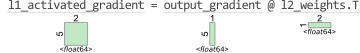

array([[-21.20705145,  -7.74114297],
       [-22.21960552,  -8.11075238],
       [-23.23215958,  -8.48036179],
       [ 17.03473309,   6.21813478],
       [ 10.53949657,   3.84719912]])

In [21]:
with exp():
    # Calculate the gradient on the output of layer 1
    l1_activated_gradient = output_gradient @ l2_weights.T

l1_activated_gradient

## Layer 1 Parameters

Now, we can calculate the gradient with respect to the parameters in layer 1 ($W_{1}$ and $B_{1}$).  Before we do this, we have to differentiate across the nonlinear activation function.

You may remember that the derivative is the rate of change of a function:

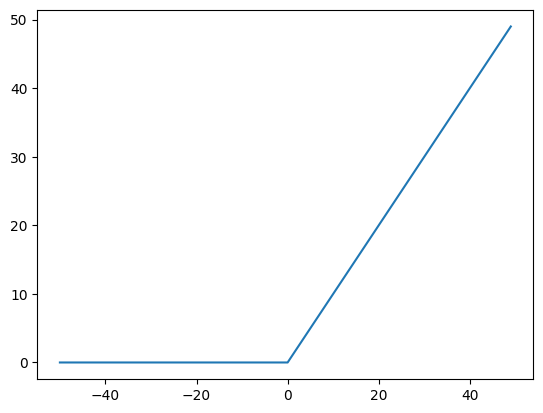

In [22]:
# Generate a range of predictions between -50 and 50.
temps = np.arange(-50,50)

# Predict tmax_tomorrow given each of our input temps
plt.plot(temps, np.maximum(0, temps))

As we can see above, the rate of change of the relu function is constant when the input is above `0`, and `0` when the input is below `0`.  The derivative of the relu function is undefined when the input equals `0` (it is `1` above and `0` below).  But by convention, we assign a derivative of `0` to the relu function at `0`.

We can plot the derivative of the relu function:

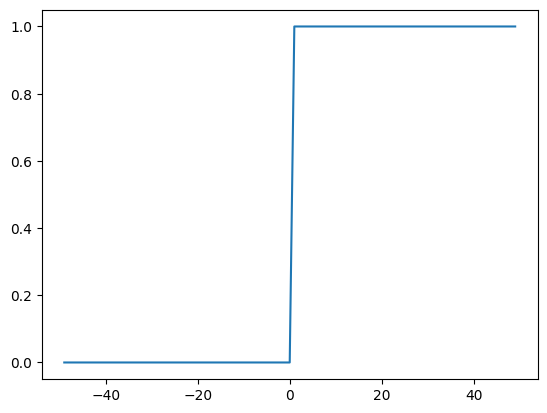

In [23]:
# Compute the relu function over the temperatures
activation = np.maximum(0, temps)

# Plot the input temperatures against the derivative of relu (the slope)
# np.roll will shift the values to the right one place, so we subtract the previous value
plt.plot(temps[1:], activation[1:] - np.roll(activation, 1)[1:])

To get from the gradient on the activation function to the pre-nonlinearity gradient, we have to multiply the gradient by `1` if the input is greater than `0`, and by `0` otherwise.  Intuitively, if the output of the nonlinearity was `0` in the forward pass, then it didn't contribute to the final prediction at all.  So this is making sure that we properly zero out our gradient at these points, matching what happened in the forward pass.

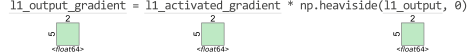

array([[-21.20705145,  -7.74114297],
       [-22.21960552,  -8.11075238],
       [-23.23215958,  -8.48036179],
       [  0.        ,   6.21813478],
       [ 10.53949657,   3.84719912]])

In [24]:
with exp():
    l1_output_gradient = l1_activated_gradient * np.heaviside(l1_output, 0)

l1_output_gradient

After doing this, the layer 1 weight and bias updates are the same as for layer 2:

In [25]:
# Calculate gradients wrt weights and biases for layer 1
l1_w_gradient =  input.T @ l1_output_gradient
l1_b_gradient = np.mean(l1_output_gradient, axis=0)

l1_weights -= l1_w_gradient * lr
l1_bias -= l1_b_gradient * lr

In [26]:
l1_weights

array([[0.8812494, 0.1236013]])

In [27]:
l1_bias

array([[11.99011224, 10.00002853]])

At this point, we can end backpropagation, since we've computed the gradients at each of our layers.

## Backpropagation

Here is the algorithm we followed:

1. Run the network forward pass, and get the output:
2. Compute gradient with respect to the outputs of the network. (the `mse_grad` function)
3. For each layer in the network:
   - Compute the gradient with respect to the pre-nonlinearity output (if the layer has a nonlinearity)
   - Compute the gradient with respect to the weights
   - Compute the gradient with respect to the biases
   - Compute the gradient with respect to the inputs to the layer
4. Update the parameters in the network using gradient descent

For convenience, we combined step 4 into step 3.  But it's important to note that backpropagation is step 3 above, and gradient descent is step 4.  Splitting these steps up makes it easier to use variations of regular gradient descent to update the weights (like Adam or RMSProp).

Steps 3 and 4 are usually called the backward pass of a neural network.

Backpropagation and gradient descent are the most complicated parts of training neural networks.  Intuitively, backpropagation is about reversing the forward pass of the network so that we can figure out how to reduce error.  To do this, we pass the loss gradient from layer to layer (applying the chain rule).

## Batch Size

In the example above, we used a **batch size** of `5`.  This means that we did the forward and backward pass using `5` inputs from the training dataset.  Larger batch sizes will use more memory, since we need to create larger matrices.  But they will also run faster, since we can process more examples at once.

Batch size also affects gradient descent.  When we process `1` example at a time, we do a backward pass using the gradient of that single example.  With a larger batch size, we're averaging the gradient over every example in the batch when we update weights and biases.  This means that we may lose some accuracy in the updates when the batch size is too high.

When the batch size is the same as the rows in the training data, then the update process is called **batch gradient descent** (confusing, I know!).  Otherwise, it is called **stochastic gradient descent**.  Either way, we still use backpropagation to find the gradients.

## Putting it all together

We now know enough to train a neural network to predict the weather!

Let's first load our data and split it into 3 sets:

- A training set, which we'll use to train our algorithm
- A validation set, which we'll use to measure error during training
- A test set, which we'll use to evaluate the model after it has been fit

Creating separate sets like this helps us avoid overfitting, where our model looks great in training, but doesn't work in the real world.

In [28]:
import numpy as np
from sklearn.preprocessing import StandardScaler
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Scale our data so relu works better
# All temperature values in the original dataset are over 0, so relu won't do much for several epochs
# Scaling will make some of the input data negative
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

split_data = np.split(data, [int(.7 * len(data)), int(.85 * len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in
                                                            split_data]

We'll train a neural network to predict `tmax_tomorrow` using `tmax`, `tmin`, and `rain`.

To train our neural network, we need 4 elements:

- A way to initialize our parameters (weights and biases for each layer)
- A `forward` pass that computes predictions using the parameters
- A loss function that measures the error of our predictions
- A `backward` pass that updates our parameters to reduce the loss

To initialize our weight parameters, we can use random initialization.  Random initialization helps the gradient descent algorithm descend to a global minimum efficiently (feel free to experiment with other initializations, like 0 or 1 to see what happens).

It's common to initialize the bias to be `1` or `0`.

We'll shrink the initial parameter values so we don't end up with predictions that are too large (this can cause gradient descent to take steps that are too large).

In [29]:
def init_layers(inputs):
    layers = []
    for i in range(1, len(inputs)):
        layers.append([
            np.random.rand(inputs[i-1], inputs[i]) / 5 - .1,
            np.ones((1,inputs[i]))
        ])
    return layers

# This will initialize weights and biases for a 3-layer neural network with 10 units in the first layer, 10 in the second, and 1 in the final
# The first number (3) is our number of input features
layer_conf = [3,10,10,1]

We initialize one weight matrix and one bias matrix for each of our layers.

In the forward pass of our network, we generate outputs for each layer by multiplying $W$ and $X$, then adding $B$.  If the layer is not our output layer, we also apply a nonlinearity (relu).

The output of the last layer is our prediction for `tmax_tomorrow`:

In [30]:
def forward(batch, layers):
    hidden = [batch.copy()]
    for i in range(len(layers)):
        batch = np.matmul(batch, layers[i][0]) + layers[i][1]
        if i < len(layers) - 1:
            batch = np.maximum(batch, 0)
        # Store the forward pass hidden values for use in backprop
        hidden.append(batch.copy())
    return batch, hidden

Once we have predictions, we need to calculate error.  We have two functions, one to calculate the loss, and one to calculate the loss gradient (which helps us update our parameters):

In [31]:
def mse(actual, predicted):
    return (actual - predicted) ** 2

def mse_grad(actual, predicted):
    return predicted - actual

In the backward pass of the network, we adjust $W$ and $B$ by the gradient times learning rate.

In [32]:
def backward(layers, hidden, grad, lr):
    for i in range(len(layers)-1, -1, -1):
        if i != len(layers) - 1:
            grad = np.multiply(grad, np.heaviside(hidden[i+1], 0))

        w_grad = hidden[i].T @ grad
        b_grad = np.mean(grad, axis=0)

        layers[i][0] -= w_grad * lr
        layers[i][1] -= b_grad * lr
        
        grad = grad @ layers[i][0].T
    return layers

Finally, we'll write a loop that:

- Makes predictions for each batch (we'll use a batch size of `8`)
- Computes the gradient for each batch
- Updates the parameters based on the gradient

We will run the algorithm for several epochs - an epoch is each iteration over the training set.  Up to a point, more epochs will improve the accuracy.

We will print out the loss on the validation set regularly so we can monitor the loss.  We know we have too many epochs if the validation loss is increasing instead of decreasing.

In [33]:
from statistics import mean

lr = 1e-6
epochs=10
batch_size = 8

layers = init_layers(layer_conf)

for epoch in range(epochs):
    epoch_loss = []

    for i in range(0, train_x.shape[0], batch_size):
        x_batch = train_x[i:(i+batch_size)]
        y_batch = train_y[i:(i+batch_size)]
        pred, hidden = forward(x_batch, layers)

        loss = mse_grad(y_batch, pred)
        epoch_loss.append(np.mean(loss ** 2))

        layers = backward(layers, hidden, loss, lr)


    valid_preds, _ = forward(valid_x, layers)

    print(f"Epoch: {epoch} Train MSE: {mean(epoch_loss)} Valid MSE: {np.mean(mse(valid_preds,valid_y))}")

Epoch: 0 Train MSE: 3298.4814409496876 Valid MSE: 1698.6755724272155
Epoch: 1 Train MSE: 345.40078470794464 Valid MSE: 27.80144186428462
Epoch: 2 Train MSE: 24.252381700389204 Valid MSE: 21.752866039853455
Epoch: 3 Train MSE: 22.69885488837237 Valid MSE: 20.965108979472102
Epoch: 4 Train MSE: 22.261625244357383 Valid MSE: 20.793625509963046
Epoch: 5 Train MSE: 22.148946241777665 Valid MSE: 20.76249233433996
Epoch: 6 Train MSE: 22.118371865472543 Valid MSE: 20.760424067388534
Epoch: 7 Train MSE: 22.108580704876303 Valid MSE: 20.762591439612102
Epoch: 8 Train MSE: 22.10415944153222 Valid MSE: 20.764782894467896
Epoch: 9 Train MSE: 22.101148121799504 Valid MSE: 20.766197583199283


We can display our final parameters from each layer:

In [34]:
layers[0]

[array([[ 0.13627073,  0.10734905,  0.17262407,  0.09384974,  0.12110305,
          0.10433614,  0.21250811,  0.05317818,  0.07851443,  0.13120318],
        [-0.04181835,  0.01112021,  0.05947605,  0.09442577,  0.01488811,
          0.03294442,  0.08459158, -0.08258339,  0.01831939,  0.04747595],
        [ 0.10899102, -0.09314925, -0.12027735, -0.04524359, -0.04634872,
         -0.00824166,  0.02547093, -0.0172699 , -0.02959506,  0.12033973]]),
 array([[1.06998918, 1.07313452, 1.06852117, 1.07559753, 1.07423911,
         1.07931344, 1.08156855, 1.05428857, 1.07007705, 1.07094374]])]

We can also measure error on the test set:

In [35]:
pred, hidden = forward(test_x, layers)
np.mean(mse(test_y, pred))

22.069973497275438

## Wrap-up

We learned a lot in this lesson!  You should now have a good idea of how to train a neural network with multiple layers, and use it to make predictions.  Trying changing batch size and learning rate to see how it affects the network.

In the next lesson, we'll cover how to do classification with a neural network.